In [975]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import QuantileTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import r2_score
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from scipy.stats import boxcox
pd.options.display.max_rows = 50
pd.options.display.max_columns = 999
import warnings
warnings.filterwarnings('ignore')

In [976]:
def load_original_data():
    return pd.read_csv("Data_Marketing_Customer_Analysis_Round2.csv" )

In [977]:
ca_df=load_original_data()

In [978]:
ca_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10910 entries, 0 to 10909
Data columns (total 26 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     10910 non-null  int64  
 1   Customer                       10910 non-null  object 
 2   State                          10279 non-null  object 
 3   Customer Lifetime Value        10910 non-null  float64
 4   Response                       10279 non-null  object 
 5   Coverage                       10910 non-null  object 
 6   Education                      10910 non-null  object 
 7   Effective To Date              10910 non-null  object 
 8   EmploymentStatus               10910 non-null  object 
 9   Gender                         10910 non-null  object 
 10  Income                         10910 non-null  int64  
 11  Location Code                  10910 non-null  object 
 12  Marital Status                 10910 non-null 

In [979]:
ca_df['Policy'].value_counts()

Personal L3     4118
Personal L2     2537
Personal L1     1473
Corporate L3    1221
Corporate L2     688
Corporate L1     432
Special L2       193
Special L3       170
Special L1        78
Name: Policy, dtype: int64

In [980]:
# categorizing Policy
def policy_category(x):
    if x[0] == 'P':
        return 'Personal'
    elif x[0] == 'C':
        return 'Corporate'
    elif x[0] == 'S':
        return 'Special'
    
ca_df['Policy'] = list(map(policy_category, ca_df['Policy']))

In [981]:
# dropping the irrelevant columns
ca_df.drop(columns=['Unnamed: 0', 'Customer', 'Effective To Date', 'Policy Type', 'Vehicle Type'], inplace=True)

In [982]:
# dropping insignificant columns (after running linear regression)
ca_df.drop(columns=['State', 'Months Since Policy Inception', 'Number of Open Complaints', 'Number of Policies', 'Sales Channel', 'Vehicle Class', 'Months Since Last Claim', 'Policy', 'Vehicle Size', 'Marital Status'], inplace=True)

In [983]:
# replacing null values
ca_df['Months Since Last Claim'].fillna(value=round(ca_df['Months Since Last Claim'].mean(axis=0),0), inplace=True)


KeyError: 'Months Since Last Claim'

In [984]:
# filtering out 0 Income
ca_df = ca_df[ca_df['Income']>0]

# removing outliners
## for Customer Lifetime Value
Q1 = ca_df['Customer Lifetime Value'].quantile(0.25)
Q3 = ca_df['Customer Lifetime Value'].quantile(0.75)
IQR = Q3 - Q1

clv_filter = (ca_df['Customer Lifetime Value'] >= Q1 - 1.5 * IQR) & (ca_df['Customer Lifetime Value'] <= Q3 + 1.5 * IQR)
ca_df = ca_df.loc[clv_filter]

# removing outliners
## for Monthly Premium Auto
Q1 = ca_df['Monthly Premium Auto'].quantile(0.25)
Q3 = ca_df['Monthly Premium Auto'].quantile(0.75)
IQR = Q3 - Q1

mpa_filter = (ca_df['Monthly Premium Auto'] >= Q1 - 1.5 * IQR) & (ca_df['Monthly Premium Auto'] <= Q3 + 1.5 * IQR)
ca_df = ca_df.loc[mpa_filter]

array([[<AxesSubplot:title={'center':'Customer Lifetime Value'}>,
        <AxesSubplot:title={'center':'Income'}>],
       [<AxesSubplot:title={'center':'Monthly Premium Auto'}>,
        <AxesSubplot:title={'center':'Total Claim Amount'}>]],
      dtype=object)

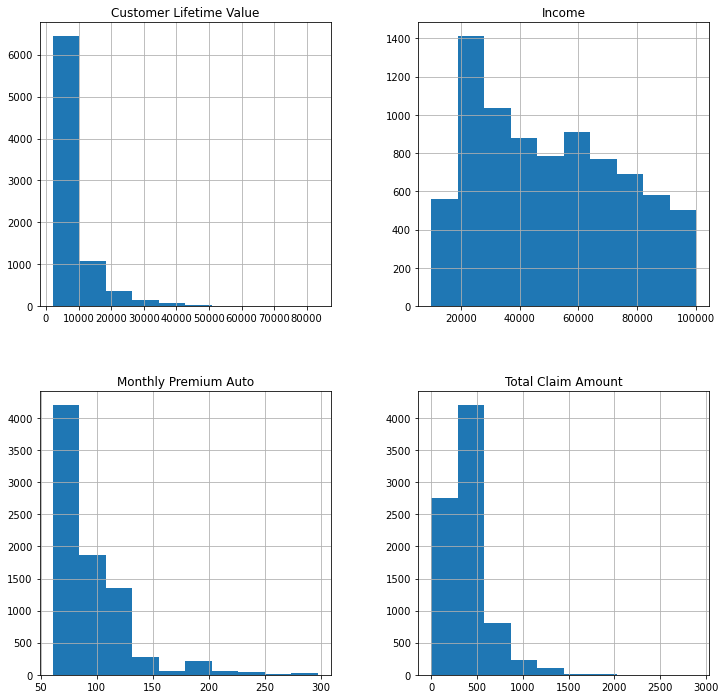

In [985]:
ca_df.hist(figsize = (12,12))

In [986]:
ca_df.corr()

,Customer Lifetime Value,Income,Monthly Premium Auto,Total Claim Amount
Customer Lifetime Value,1.000000,0.005777,0.409281,0.258591
Income,0.005777,1.000000,-0.004379,-0.220282
Monthly Premium Auto,0.409281,-0.004379,1.000000,0.635330
Total Claim Amount,0.258591,-0.220282,0.635330,1.000000


In [987]:
# identifying categorical columns
categorical_features = ca_df.select_dtypes('object')
categorical_features

,Response,Coverage,Education,EmploymentStatus,Gender,Location Code,Renew Offer Type
0,No,Basic,College,Employed,M,Suburban,Offer3
2,No,Basic,Bachelor,Employed,M,Suburban,Offer3
3,Yes,Extended,College,Employed,M,Suburban,Offer2
4,No,Premium,Bachelor,Medical Leave,F,Suburban,Offer1
5,NaN,Basic,High School or Below,Employed,M,Suburban,Offer1
...,...,...,...,...,...,...,...
10902,No,Extended,High School or Below,Employed,F,Suburban,Offer2
10903,No,Basic,College,Employed,M,Suburban,Offer2
10906,No,Basic,College,Employed,F,Urban,Offer2
10907,No,Extended,Bachelor,Employed,F,Rural,Offer1


In [988]:
ca_df['Education'].value_counts(dropna=False)

Bachelor                2408
College                 2385
High School or Below    2216
Master                   776
Doctor                   338
Name: Education, dtype: int64

# ca_df['Coverage'].value_counts()

# label encoding for Education
def education_label(x):
    if x == 'High School or Below':
        return 0
    elif x == 'College':
        return 1
    elif x == 'Bachelor':
        return 2
    elif x == 'Master':
        return 3
    elif x == 'Doctor':
        return 4

ca_df['Education Transformed'] = list(map(education_label, ca_df['Education']))

# label encoding for Coverage
def coverage_label(x):
    if x == 'Basic':
        return 0
    elif x == 'Extended':
        return 1
    elif x == 'Premium':
        return 2

ca_df['Coverage Transformed'] = list(map(coverage_label, ca_df['Coverage']))

In [989]:
# replacing the Education and Coverage column
ca_df.drop(columns=['Education', 'Coverage'], inplace=True)

In [990]:
# creating X-y split
X = ca_df.drop('Total Claim Amount', axis = 1)
y = ca_df['Total Claim Amount']

In [991]:
numericals = X._get_numeric_data()
numericals

,Customer Lifetime Value,Income,Monthly Premium Auto
0,4809.216960,48029,61
2,14947.917300,22139,100
3,22332.439460,49078,97
4,9025.067525,23675,117
5,4745.181764,50549,61
...,...,...,...
10902,3579.023825,28304,91
10903,2771.663013,59855,74
10906,5259.444853,61146,65
10907,23893.304100,39837,201


In [992]:
categoricals = X.select_dtypes('object')
categoricals

,Response,EmploymentStatus,Gender,Location Code,Renew Offer Type
0,No,Employed,M,Suburban,Offer3
2,No,Employed,M,Suburban,Offer3
3,Yes,Employed,M,Suburban,Offer2
4,No,Medical Leave,F,Suburban,Offer1
5,NaN,Employed,M,Suburban,Offer1
...,...,...,...,...,...
10902,No,Employed,F,Suburban,Offer2
10903,No,Employed,M,Suburban,Offer2
10906,No,Employed,F,Urban,Offer2
10907,No,Employed,F,Rural,Offer1


In [993]:
# one hot encoding
categoricals = pd.get_dummies(categoricals, drop_first=True)

In [994]:
categoricals

,Response_Yes,EmploymentStatus_Employed,EmploymentStatus_Medical Leave,EmploymentStatus_Retired,Gender_M,Location Code_Suburban,Location Code_Urban,Renew Offer Type_Offer2,Renew Offer Type_Offer3,Renew Offer Type_Offer4
0,0,1,0,0,1,1,0,0,1,0
2,0,1,0,0,1,1,0,0,1,0
3,1,1,0,0,1,1,0,1,0,0
4,0,0,1,0,0,1,0,0,0,0
5,0,1,0,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
10902,0,1,0,0,0,1,0,1,0,0
10903,0,1,0,0,1,1,0,1,0,0
10906,0,1,0,0,0,0,1,1,0,0
10907,0,1,0,0,0,0,0,0,0,0


In [995]:
# combining the processed numerical and categorical columns
all_features = pd.concat([numericals, categoricals], axis=1)
all_features

,Customer Lifetime Value,Income,Monthly Premium Auto,Response_Yes,EmploymentStatus_Employed,EmploymentStatus_Medical Leave,EmploymentStatus_Retired,Gender_M,Location Code_Suburban,Location Code_Urban,Renew Offer Type_Offer2,Renew Offer Type_Offer3,Renew Offer Type_Offer4
0,4809.216960,48029,61,0,1,0,0,1,1,0,0,1,0
2,14947.917300,22139,100,0,1,0,0,1,1,0,0,1,0
3,22332.439460,49078,97,1,1,0,0,1,1,0,1,0,0
4,9025.067525,23675,117,0,0,1,0,0,1,0,0,0,0
5,4745.181764,50549,61,0,1,0,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10902,3579.023825,28304,91,0,1,0,0,0,1,0,1,0,0
10903,2771.663013,59855,74,0,1,0,0,1,1,0,1,0,0
10906,5259.444853,61146,65,0,1,0,0,0,0,1,1,0,0
10907,23893.304100,39837,201,0,1,0,0,0,0,0,0,0,0


In [996]:
X_train, X_test, y_train, y_test = train_test_split(all_features, y, test_size = 0.30, random_state = 100)

In [997]:
# standardizing the data
std_scaler = StandardScaler().fit(X_train) ## fit is to find the mean and variance of the train set
X_train_scaled = std_scaler.transform(X_train) ## transform to normal distribution after the splitting based on the train set

In [998]:
X_test_scaled = std_scaler.transform(X_test) ## Don't need to fit again as we need to apply the same mean and variance applied for fitting the X_train. Just to transofrm to normal distribution based on the test set

In [999]:
# applying linear regression
model = LinearRegression()
model.fit(X_train_scaled, y_train)

LinearRegression()

In [1000]:
X.columns

Index(['Customer Lifetime Value', 'Response', 'EmploymentStatus', 'Gender',
       'Income', 'Location Code', 'Monthly Premium Auto', 'Renew Offer Type'],
      dtype='object')

In [1001]:
model.coef_

array([  1.94954737,  -6.48476146, 152.13459697,  -2.17233396,
        -2.53473156,   3.47258852,  -2.9664709 ,   4.88228899,
       190.55192846,  92.16650613,   6.54328913,   4.12399127,
         2.51891998])

In [1002]:
model.intercept_

379.6711315400986

In [1003]:
model.score(X_test_scaled, y_test)

0.8041845886203839

In [1004]:
# checking the model prediction
y_pred = model.predict(X_test_scaled)

In [1005]:
y_test

7374     183.117146
8350       6.422285
4285     523.200000
10439    643.200000
1492     381.570261
            ...    
2518     145.448401
4164      33.192803
3401     552.000000
4680     475.200000
9650     586.921708
Name: Total Claim Amount, Length: 2437, dtype: float64

In [1006]:
y_pred

array([194.69057828, -26.27881131, 580.54023153, ..., 600.65827691,
       526.59141908, 452.7818389 ])

In [1007]:
result = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})

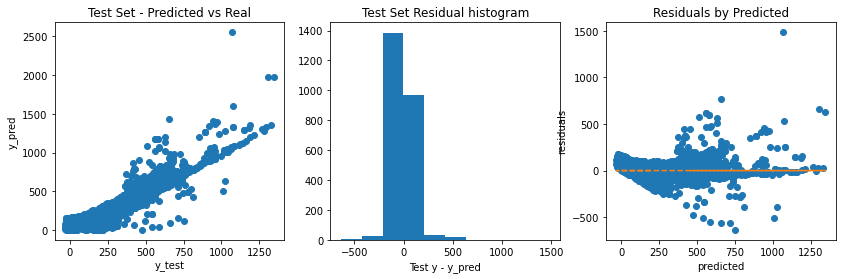

In [1008]:
fig, ax = plt.subplots(1,3,figsize=(14,4))
ax[0].plot(y_pred, y_test, 'o')
ax[0].set_xlabel("y_test")
ax[0].set_ylabel("y_pred")
ax[0].set_title("Test Set - Predicted vs Real")

ax[1].hist(y_test - y_pred)
ax[1].set_xlabel("Test y - y_pred")
ax[1].set_title("Test Set Residual histogram")

ax[2].plot(y_pred, y_test - y_pred,"o")
ax[2].set_xlabel("predicted")
ax[2].set_ylabel("residuals")
ax[2].set_title("Residuals by Predicted")
ax[2].plot(y_pred,np.zeros(len(y_pred)),linestyle='dashed')

In [1009]:
# MSE
MSE = mse(y_test, y_pred)
MSE

11861.437630904235

In [1010]:
# RMSE
RMSE = np.sqrt(MSE)
RMSE

108.91022739350164

In [1011]:
# MAE
MAE = mae(y_test, y_pred)
MAE

75.1138894038113

In [1012]:
R2 = r2_score(y_test, y_pred)
R2

0.8041845886203839

In [1013]:
Adj_R2 = 1-((1-R2)*(len(y_test)-1)/((len(y_test)-X_test.shape[1]-1)))
Adj_R2

0.8031339900450909

In [926]:
features_importance = pd.DataFrame(data = {
    'Attribute': X_train.columns,
    'Importance': abs(model.coef_)
})
features_importance = features_importance.sort_values(by='Importance', ascending=False)

In [927]:
features_importance

,Attribute,Importance
8,Location Code_Suburban,190.500538
2,Monthly Premium Auto,152.171485
9,Location Code_Urban,92.187505
12,Renew Offer Type_Offer2,7.085981
1,Income,6.427495
7,Gender_M,4.696600
13,Renew Offer Type_Offer3,4.511241
5,EmploymentStatus_Medical Leave,3.338096
6,EmploymentStatus_Retired,3.191944
14,Renew Offer Type_Offer4,2.936382
